In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

In [3]:
# Set random seed
random.seed(1337)

In [4]:
# Import seed
data = pd.read_csv('../data/data.csv')

In [5]:
data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [6]:
# Check for null values
data.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [7]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [16]:
if not os.path.exists('../pickle_objs'):
    os.makedirs('../pickle_objs')

In [34]:
# Load train+validation data
X_train = pickle.load(open('../data/X_train.pkl','rb'))
y_train = pickle.load(open('../data/y_train.pkl','rb'))
X_train_val = pickle.load(open('../data/X_train_val_os.pkl','rb'))
y_train_val = pickle.load(open('../data/y_train_val_os.pkl','rb'))
X_test = pickle.load(open('../data/X_test.pkl','rb'))
y_test = pickle.load(open('../data/y_test.pkl','rb'))

In [8]:
# # Split data into train (0.8), validation (0.2), and test (0.2) sets
# X_train_val, X_test, y_train_val, y_test = train_test_split(data.drop(target_cols, axis=1), data[target_cols], test_size=0.2, random_state=1337)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1337)

In [28]:
X_train.head()

,id,comment_text
101689,202d64bd4c2bd9a4,champion hurdle delighted use 1 2_3 image uplo...
26429,4601831cd03ec679,edit war currently appear engage edit war note...
62499,a73c6f5b69d963be,-pron- wrong bud ready use taran boi verdict n...
10145,1ad558921b36c611,attempt change las vegas season las vegas augu...
16254,2adc0c27c1165eef,people arab homosexual bad thing d**n f***in h...


In [29]:
# Print value counts for train targets
for col in target_cols:
    print(y_train[col].value_counts())

0    86620
1     9122
Name: toxic, dtype: int64
0    94780
1      962
Name: severe_toxic, dtype: int64
0    90648
1     5094
Name: obscene, dtype: int64
0    95467
1      275
Name: threat, dtype: int64
0    90993
1     4749
Name: insult, dtype: int64
0    94878
1      864
Name: identity_hate, dtype: int64


In [30]:
# Print value counts for validation targets
for col in target_cols:
    print(y_val[col].value_counts())

0    28866
1     3048
Name: toxic, dtype: int64
0    31597
1      317
Name: severe_toxic, dtype: int64
0    30231
1     1683
Name: obscene, dtype: int64
0    31820
1       94
Name: threat, dtype: int64
0    30363
1     1551
Name: insult, dtype: int64
0    31648
1      266
Name: identity_hate, dtype: int64


In [31]:
# Print value counts for test targets
for col in target_cols:
    print(y_test[col].value_counts())

0    28791
1     3124
Name: toxic, dtype: int64
0    31599
1      316
Name: severe_toxic, dtype: int64
0    30243
1     1672
Name: obscene, dtype: int64
0    31806
1      109
Name: threat, dtype: int64
0    30338
1     1577
Name: insult, dtype: int64
0    31640
1      275
Name: identity_hate, dtype: int64


In [32]:
# Print value counts for train+validation targets
for col in target_cols:
    print(y_train_val[col].value_counts())

0    116205
1     27822
Name: toxic, dtype: int64
0    135040
1      8987
Name: severe_toxic, dtype: int64
0    124766
1     19261
Name: obscene, dtype: int64
0    136916
1      7111
Name: threat, dtype: int64
0    125222
1     18805
Name: insult, dtype: int64
0    135321
1      8706
Name: identity_hate, dtype: int64


In [33]:
predicted = pd.DataFrame()
for col in target_cols:
    predicted[col] = [0]*y_test.shape[0]
predicted.head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [35]:
# Compute (trivially) ROC-AUC when predicting majority class
auc_average = []
for col in target_cols:
    fpr, tpr, threshold = roc_curve(y_test[col], predicted[col])
    auc_average.append(auc(fpr, tpr))
print('ROC-AUC When Predicting Majority Class (all zeros) =', np.mean(auc_average))

ROC-AUC When Predicting Majority Class (all zeros) = 0.5


In [36]:
num_feats = 1000
n_grams = 2
ngram_range = list(map(lambda x:x+1,range(n_grams)))

In [18]:
# Fit Count Vectorizer
if(os.path.isfile('../pickle_objs/countvec_{}_ngrams_{}.pkl'.format(num_feats,n_grams))):
    countvec = pickle.load(open('../pickle_objs/countvec_{}_ngrams_{}.pkl'.format(num_feats,n_grams), 'rb'))
else:
    countvec = CountVectorizer(analyzer='word', lowercase=True, max_features=num_feats,ngram_range=ngram_range)
    countvec.fit(X_train_val['comment_text'])
    pickle.dump(countvec,open('../pickle_objs/countvec_{}_ngrams_{}.pkl'.format(num_feats,n_grams),'wb'))

# Fit TF-IDF Vectorizer
if(os.path.isfile('../pickle_objs/tfidf_{}_ngrams_{}.pkl'.format(num_feats,n_grams))):
    tfidf = pickle.load(open('../pickle_objs/tfidf_{}_ngrams_{}.pkl'.format(num_feats,n_grams), 'rb'))
else:
    tfidf = TfidfVectorizer(analyzer='word', lowercase=True, max_features=1000,ngram_range=ngram_range)
    tfidf.fit(X_train_val['comment_text'])
    pickle.dump(tfidf,open('../pickle_objs/tfidf_{}_ngrams_{}.pkl'.format(num_feats,n_grams),'wb'))


In [20]:
# Transform data as per Count Vectorizer
X_train_val_countvec = countvec.transform(X_train_val['comment_text'])
X_test_countvec = countvec.transform(X_test['comment_text'])

# Transform data as per TF-IDF Vectorizer
X_train_val_tfidf = tfidf.transform(X_train_val['comment_text'])
X_test_tfidf = tfidf.transform(X_test['comment_text'])

In [38]:
# Fit individual BernoulliNB models for each target with Count Vectorizer
bnb_countvec = BinaryRelevance(BernoulliNB())
bnb_countvec.fit(X_train_val_countvec, y_train_val)
predictions_bnb_countvec = bnb_countvec.predict_proba(X_test_countvec)

# Fit individual GaussianNB models for each target with Count Vectorizer
gnb_countvec = BinaryRelevance(GaussianNB())
gnb_countvec.fit(X_train_val_countvec, y_train_val)
predictions_gnb_countvec = gnb_countvec.predict_proba(X_test_countvec)

# Fit individual GaussianNB models for each target with TF-IDF Vectorizer
gnb_tfidf = BinaryRelevance(GaussianNB())
gnb_tfidf.fit(X_train_val_tfidf, y_train_val)
predictions_gnb_tfidf = gnb_tfidf.predict_proba(X_test_tfidf)

# Fit individual GaussianNB models for each target with TF-IDF Vectorizer
lr_tfidf = BinaryRelevance(LogisticRegression(penalty='l1'))
lr_tfidf.fit(X_train_val_tfidf, y_train_val)
predictions_lr_tfidf = lr_tfidf.predict_proba(X_test_tfidf)

# Fit individual GaussianNB models for each target with TF-IDF Vectorizer
lr2_tfidf = BinaryRelevance(LogisticRegression(penalty='l2'))
lr2_tfidf.fit(X_train_val_tfidf, y_train_val)
predictions_lr2_tfidf = lr2_tfidf.predict_proba(X_test_tfidf)


# # Fit individual GaussianNB models for each target with TF-IDF Vectorizer
# scaler = preprocessing.StandardScaler().fit(X_train_val_tfidf)
# X_train_val_tfidf = scaler.transform(X_train_val_tfidf)
# X_test_tfidf = scaler.transform(X_test_tfidf)
# svc_tfidf = BinaryRelevance(SVC(kernel='linear'))
# svc_tfidf.fit(X_train_val_tfidf, y_train_val)
# predictions_svc_tfidf = svc_tfidf.predict_proba(X_test_tfidf)

In [46]:
# Predict probabilities of each class for Count Vectorizer (BernoulliNB)
probabilities_bnb_countvec = np.squeeze(np.asarray(predictions_bnb_countvec.todense()))

# Predict probabilities of each class for Count Vectorizer and TF-IDF Vectorizer (GaussianNB)
probabilities_gnb_countvec = np.squeeze(np.asarray(predictions_gnb_countvec.todense()))
probabilities_gnb_tfidf = np.squeeze(np.asarray(predictions_gnb_tfidf.todense()))


# Predict probabilities of each class for TF-IDF Vectorizer (LogisticRegression)
probabilities_lr_tfidf = np.squeeze(np.asarray(predictions_lr_tfidf.todense()))

# Predict probabilities of each class for TF-IDF Vectorizer (LogisticRegression)
probabilities_lr2_tfidf = np.squeeze(np.asarray(predictions_lr2_tfidf.todense()))

# # Predict probabilities of each class for TF-IDF Vectorizer (SVC(linear kernel))
# probabilities_svc_tfidf = np.squeeze(np.asarray(predictions_svc_tfidf.todense()))

In [65]:
len(probabilities_rf_countvec[0])

31915

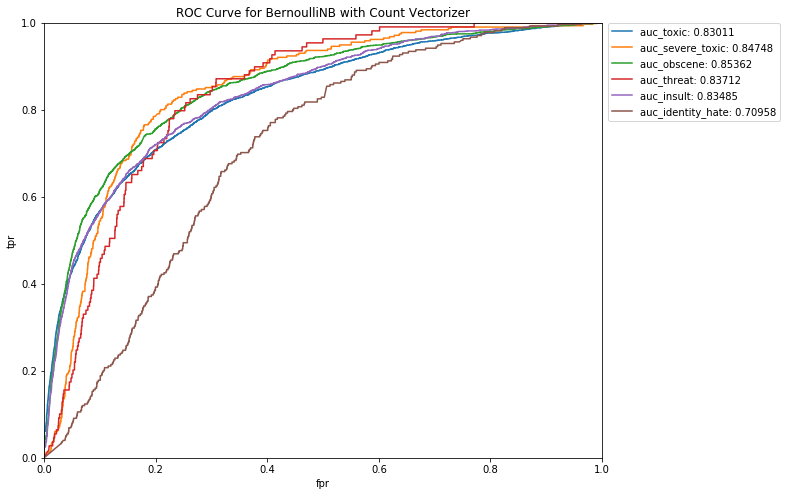

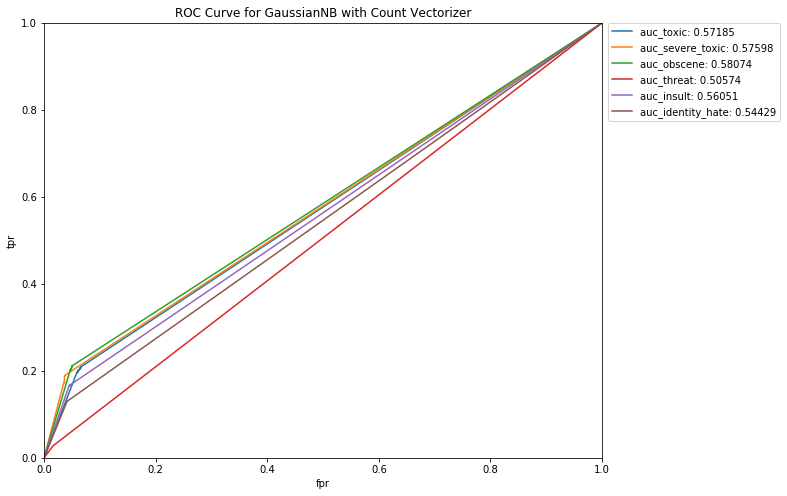

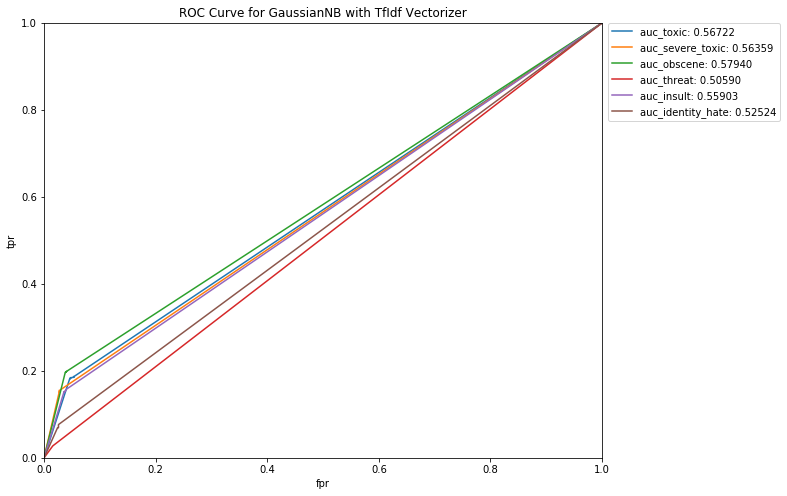

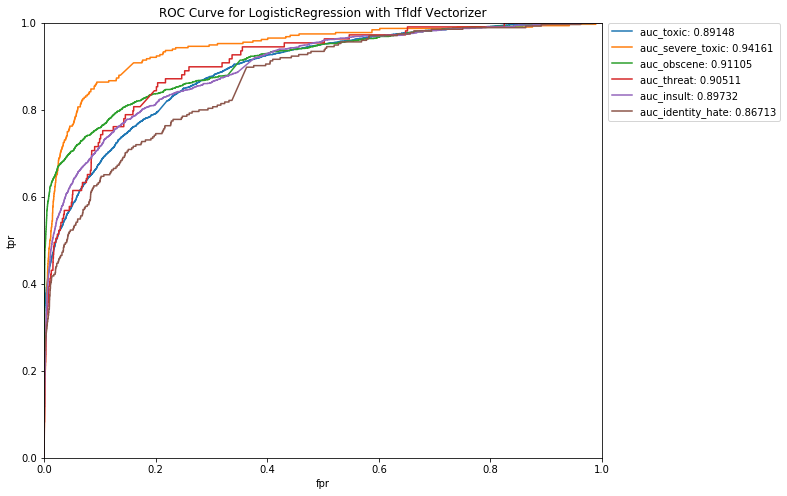

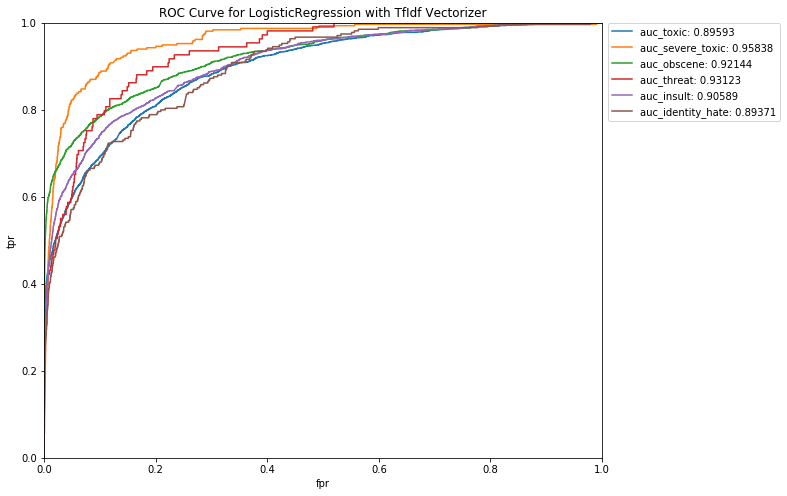

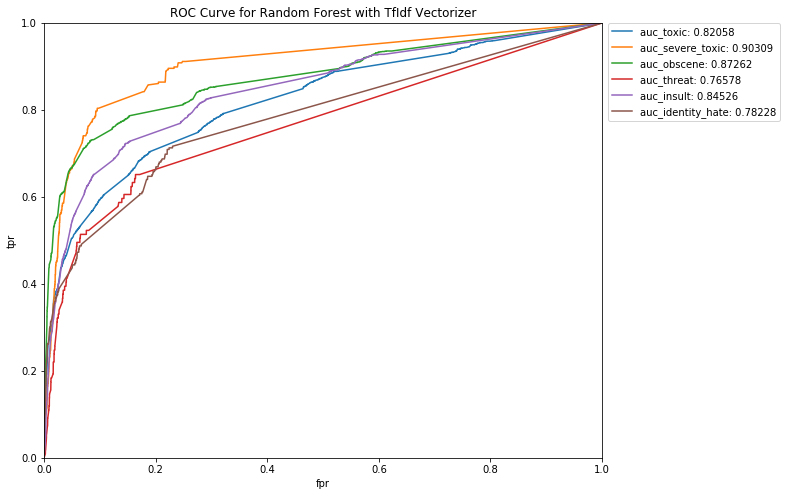

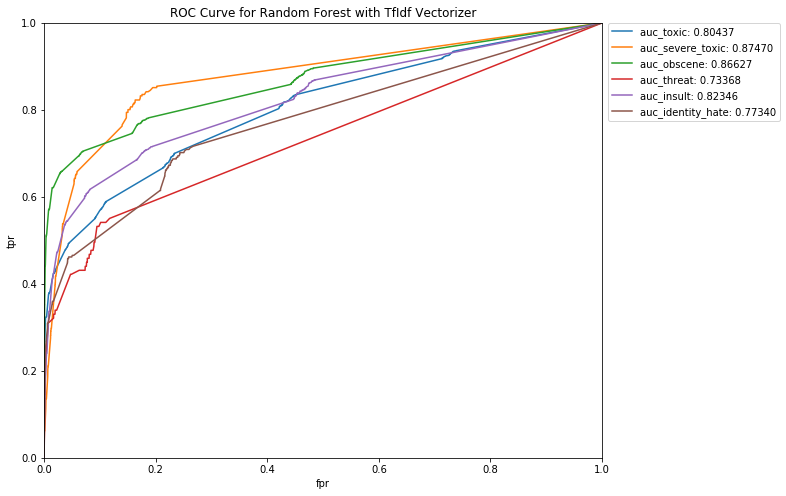

In [67]:
# Compute ROC-AUC values of each class for Count Vectorizer (BernoulliNB)
auc_bnb_countvec = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_bnb_countvec[:,i])
    auc_value = auc(fpr, tpr)
    auc_bnb_countvec.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for BernoulliNB with Count Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()
    
# Compute ROC-AUC values of each class for Count Vectorizer (GaussianNB)
auc_gnb_countvec = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_gnb_countvec[:,i])
    auc_value = auc(fpr, tpr)
    auc_gnb_countvec.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for GaussianNB with Count Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# Compute ROC-AUC values of each class for TfIdf Vectorizer (GaussianNB)
auc_gnb_tfidf = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_gnb_tfidf[:,i])
    auc_value = auc(fpr, tpr)
    auc_gnb_tfidf.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for GaussianNB with TfIdf Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# Compute ROC-AUC values of each class for TfIdf Vectorizer (Logistic Regression)
auc_lr_tfidf = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_lr_tfidf[:,i])
    auc_value = auc(fpr, tpr)
    auc_lr_tfidf.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for LogisticRegression with TfIdf Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# Compute ROC-AUC values of each class for TfIdf Vectorizer (Logistic Regression l2 penalty)
auc_lr2_tfidf = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_lr2_tfidf[:,i])
    auc_value = auc(fpr, tpr)
    auc_lr2_tfidf.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for LogisticRegression with TfIdf Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# Compute ROC-AUC values of each class for Count Vectorizer (RandomForestClassifier)
auc_rf_countvec = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_rf_countvec[i][:,1])
    auc_value = auc(fpr, tpr)
    auc_rf_countvec.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for Random Forest with TfIdf Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# Compute ROC-AUC values of each class for TfIdf Vectorizer (RandomForestClassifier)
auc_rf_tfidf = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_rf_tfidf[i][:,1])
    auc_value = auc(fpr, tpr)
    auc_rf_tfidf.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for Random Forest with TfIdf Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# # Compute ROC-AUC values of each class for TfIdf Vectorizer (SVC(linear kernel))
# auc_svc_tfidf = []
# plt.figure(figsize=(10,8))
# for i, col in enumerate(target_cols):
#     fpr, tpr, threshold = roc_curve(y_test[col], probabilities_svc_tfidf[:,i])
#     auc_value = auc(fpr, tpr)
#     auc_svc_tfidf.append(auc_value)
#     plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
# plt.xlabel('fpr')
# plt.ylabel('tpr')
# plt.title('ROC Curve for LogisticRegression with TfIdf Vectorizer')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# plt.show()

In [68]:
# Get mean column-wise ROC-AUC values
print('ROC-AUC for BernoulliNB with Count Vectorizer = {:.4f}'.format(np.mean(auc_bnb_countvec)))
print('ROC-AUC for GaussianNB with Count Vectorizer = {:.4f}'.format(np.mean(auc_gnb_countvec)))
print('ROC-AUC for RandomForest with Count Vectorizer = {:.4f}'.format(np.mean(auc_rf_countvec)))
print('ROC-AUC for GaussianNB with TfIdf Vectorizer = {:.4f}'.format(np.mean(auc_gnb_tfidf)))
print('ROC-AUC for LogisticRegression with TfIdf Vectorizer = {:.4f}'.format(np.mean(auc_lr_tfidf)))
print('ROC-AUC for LogisticRegression with TfIdf Vectorizer = {:.4f}'.format(np.mean(auc_lr2_tfidf)))
print('ROC-AUC for RandomForest with TfIdf Vectorizer = {:.4f}'.format(np.mean(auc_rf_tfidf)))

# print('ROC-AUC for SVC with TfIdf Vectorizer = {:.4f}'.format(np.mean(auc_svc_tfidf)))

ROC-AUC for BernoulliNB with Count Vectorizer = 0.8188
ROC-AUC for GaussianNB with Count Vectorizer = 0.5565
ROC-AUC for RandomForest with Count Vectorizer = 0.8316
ROC-AUC for GaussianNB with TfIdf Vectorizer = 0.5501
ROC-AUC for LogisticRegression with TfIdf Vectorizer = 0.9023
ROC-AUC for LogisticRegression with TfIdf Vectorizer = 0.9178
ROC-AUC for RandomForest with TfIdf Vectorizer = 0.8126


In [69]:
aucs = pd.DataFrame()
aucs['bnb_countvec'] = auc_bnb_countvec
aucs['gnb_countvec'] = auc_gnb_countvec
aucs['rf_countvec'] = auc_rf_countvec
aucs['gnb_tfidfvec'] = auc_gnb_tfidf
aucs['lr_tfidfvec'] = auc_lr_tfidf
aucs['lr2_tfidfvec'] = auc_lr2_tfidf
aucs['rf_tfidfvec'] = auc_rf_tfidf

# aucs['svc_tfidfvec'] = auc_svc_tfidf

aucs = aucs.T
aucs.columns = target_cols
aucs['mean'] = np.mean(aucs[target_cols], axis=1)
aucs

,toxic,severe_toxic,obscene,threat,insult,identity_hate,mean
bnb_countvec,0.830109,0.847477,0.853616,0.837121,0.834847,0.709575,0.818791
gnb_countvec,0.571853,0.575983,0.580736,0.505744,0.560509,0.544291,0.556519
rf_countvec,0.820581,0.903094,0.872623,0.765778,0.845262,0.782281,0.831603
gnb_tfidfvec,0.567220,0.563585,0.579395,0.505902,0.559032,0.525236,0.550062
lr_tfidfvec,0.891485,0.941606,0.911054,0.905111,0.897320,0.867129,0.902284
lr2_tfidfvec,0.895928,0.958377,0.921444,0.931235,0.905887,0.893713,0.917764
rf_tfidfvec,0.804369,0.874696,0.866269,0.733682,0.823458,0.773400,0.812646
